# Fraud Detection in Electricity and Gas Consumption Challenge

This is a simple starter notebook based on the tutorial prepared by Joy Wawira. Check out the article [here](https://zindi.africa/learn/fraud-detection-in-electricity-and-gas-consumption-challenge-tutorial) for a more detailed description of the steps taken.

This notebook covers:
- Downloading the data straight from Zindi and onto colab
- Loading the data and carrying out simple EDA to understand the data and prepare for modelling 
- Preprocessing the data and feature engineering 
- Creating a simple LGBM model and predicting on the test set
- Prepare submission file and save as csv
- Some tips on how to improve model performance and your score

# Pre-Requisites

In [125]:
DATA_DIR = '/content'

TRAIN_DIR = f'{DATA_DIR}/train'
TEST_DIR = f'{DATA_DIR}/test'

OUTPUT_DIR = f'{DATA_DIR}/output'

## Download and extract files

In [126]:
'''
import os.path
from os import path

for pth in [TRAIN_DIR, TEST_DIR, OUTPUT_DIR]:
  if path.exists(pth) == False:
    os.mkdir(pth)

'''

'\nimport os.path\nfrom os import path\n\nfor pth in [TRAIN_DIR, TEST_DIR, OUTPUT_DIR]:\n  if path.exists(pth) == False:\n    os.mkdir(pth)\n\n'

In [127]:
#only run this cell once, at the start
import requests, os

train_zip = "train.zip"
test_zip = "test.zip"
sample_sub = "SampleSubmission.csv"

In [128]:
!unzip "/content/train/train.zip" -d "/content/train/"
!unzip "/content/test/test.zip" -d "/content/test/"

unzip:  cannot find or open /content/train/train.zip, /content/train/train.zip.zip or /content/train/train.zip.ZIP.
unzip:  cannot find or open /content/test/test.zip, /content/test/test.zip.zip or /content/test/test.zip.ZIP.


# Data Prep

## Import Libraries

In [129]:
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm
from lightgbm import LGBMClassifier

import warnings
warnings.simplefilter('ignore')



## Read the Data

In [130]:
TRAIN_DIR = "data/train"
TEST_DIR = "data/test"
DATA_DIR = "data"
client_train = pd.read_csv(f'{TRAIN_DIR}/client_train.csv', low_memory=False)
invoice_train = pd.read_csv(f'{TRAIN_DIR}/invoice_train.csv', low_memory=False)

client_test = pd.read_csv(f'{TEST_DIR}/client_test.csv', low_memory=False)
invoice_test = pd.read_csv(f'{TEST_DIR}/invoice_test.csv', low_memory=False)
sample_submission = pd.read_csv(f'{DATA_DIR}/SampleSubmission.csv', low_memory=False)

## Data Understanding

In [131]:
#compare size of the various datasets
print(client_train.shape, invoice_train.shape, client_test.shape, invoice_train.shape)

(135493, 6) (4476749, 16) (58069, 5) (4476749, 16)


In [132]:
#print top rows of dataset
invoice_train.head()

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC


In [133]:
#invoice_train['invoice_date'] = pd.to_datetime(invoice_train['invoice_date'])#, format='%d/%m/%Y')
#invoice_test['invoice_date'] = pd.to_datetime(invoice_test['invoice_date'])#, format='%d/%m/%Y')

In [134]:
invoice_train.head()

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC


In [135]:
client_train.head()

,disrict,client_id,client_catg,region,creation_date,target
0,60,train_Client_0,11,101,31/12/1994,0.0
1,69,train_Client_1,11,107,29/05/2002,0.0
2,62,train_Client_10,11,301,13/03/1986,0.0
3,69,train_Client_100,11,105,11/07/1996,0.0
4,62,train_Client_1000,11,303,14/10/2014,0.0


In [136]:
invoice_train["counter_coefficient"].sort_values()
invoice_train["counter_coefficient"].nunique()

16

In [137]:

invoice_train["reading_remarque"].sort_values(ascending=True)

3704439      5
4476748      6
3262542      6
1659782      6
3262538      6
          ... 
2556034    413
2556043    413
2556044    413
2556035    413
2556037    413
Name: reading_remarque, Length: 4476749, dtype: int64

In [138]:
#print top rows of dataset
client_train.head()

,disrict,client_id,client_catg,region,creation_date,target
0,60,train_Client_0,11,101,31/12/1994,0.0
1,69,train_Client_1,11,107,29/05/2002,0.0
2,62,train_Client_10,11,301,13/03/1986,0.0
3,69,train_Client_100,11,105,11/07/1996,0.0
4,62,train_Client_1000,11,303,14/10/2014,0.0


In [139]:
#client_train['creation_date'] = pd.to_datetime(client_train['creation_date'])#, format='%d/%m/%Y')
#client_test['creation_date'] = pd.to_datetime(client_test['creation_date'])#, format='%d/%m/%Y')

In [140]:
#Get a summary for all numerical columns
invoice_train.describe()

,tarif_type,counter_number,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number
count,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06
mean,2.012804e+01,1.230587e+11,1.724884e+02,7.321702e+00,1.003040e+00,4.109795e+02,1.093225e+02,2.030620e+01,5.292588e+01,1.776700e+04,1.834970e+04,4.483095e+01
std,1.347256e+01,1.657267e+12,1.338871e+02,1.571654e+00,3.083466e-01,7.573080e+02,1.220123e+03,1.574239e+02,8.754725e+02,4.036693e+04,4.095321e+04,3.128335e+03
min,8.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.100000e+01,1.211080e+05,5.000000e+00,6.000000e+00,1.000000e+00,7.900000e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.791000e+03,2.056000e+03,4.000000e+00
50%,1.100000e+01,4.945610e+05,2.030000e+02,8.000000e+00,1.000000e+00,2.740000e+02,0.000000e+00,0.000000e+00,0.000000e+00,7.690000e+03,8.192000e+03,4.000000e+00
75%,4.000000e+01,1.115161e+06,2.070000e+02,9.000000e+00,1.000000e+00,6.000000e+02,0.000000e+00,0.000000e+00,0.000000e+00,2.166000e+04,2.234300e+04,4.000000e+00
max,4.500000e+01,2.798115e+13,6.000000e+02,4.130000e+02,5.000000e+01,9.999100e+05,9.990730e+05,6.449200e+04,5.479460e+05,2.800280e+06,2.870972e+06,6.366240e+05


In [141]:
#Get a summary for all numerical columns
client_train.describe()

,disrict,client_catg,region,target
count,135493.000000,135493.000000,135493.000000,135493.000000
mean,63.511222,11.512506,206.159809,0.055841
std,3.354400,4.423761,104.207044,0.229614
min,60.000000,11.000000,101.000000,0.000000
25%,62.000000,11.000000,103.000000,0.000000
50%,62.000000,11.000000,107.000000,0.000000
75%,69.000000,11.000000,307.000000,0.000000
max,69.000000,51.000000,399.000000,1.000000


In [142]:
#Get concise information of each column in dataset
invoice_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4476749 entries, 0 to 4476748
Data columns (total 16 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   client_id             object
 1   invoice_date          object
 2   tarif_type            int64 
 3   counter_number        int64 
 4   counter_statue        object
 5   counter_code          int64 
 6   reading_remarque      int64 
 7   counter_coefficient   int64 
 8   consommation_level_1  int64 
 9   consommation_level_2  int64 
 10  consommation_level_3  int64 
 11  consommation_level_4  int64 
 12  old_index             int64 
 13  new_index             int64 
 14  months_number         int64 
 15  counter_type          object
dtypes: int64(12), object(4)
memory usage: 546.5+ MB


In [143]:
#Get concise information of each column in dataset
client_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   disrict        135493 non-null  int64  
 1   client_id      135493 non-null  object 
 2   client_catg    135493 non-null  int64  
 3   region         135493 non-null  int64  
 4   creation_date  135493 non-null  object 
 5   target         135493 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 6.2+ MB


In [144]:
#Getting unique values on the invoice train data
for col in invoice_train.columns:
    print(f"{col} - {invoice_train[col].nunique()}")

client_id - 135493
invoice_date - 8275
tarif_type - 17
counter_number - 201893
counter_statue - 12
counter_code - 42
reading_remarque - 8
counter_coefficient - 16
consommation_level_1 - 8295
consommation_level_2 - 12576
consommation_level_3 - 2253
consommation_level_4 - 12075
old_index - 155648
new_index - 157980
months_number - 1370
counter_type - 2


In [145]:
#Getting unique values on the invoice train data
for col in client_train.columns:
    print(f"{col} - {client_train[col].nunique()}")

disrict - 4
client_id - 135493
client_catg - 3
region - 25
creation_date - 8088
target - 2


In [146]:
#check for missing values
invoice_train.isnull().sum()

client_id               0
invoice_date            0
tarif_type              0
counter_number          0
counter_statue          0
counter_code            0
reading_remarque        0
counter_coefficient     0
consommation_level_1    0
consommation_level_2    0
consommation_level_3    0
consommation_level_4    0
old_index               0
new_index               0
months_number           0
counter_type            0
dtype: int64

In [147]:
#check for missing values
client_train.isnull().sum()

disrict          0
client_id        0
client_catg      0
region           0
creation_date    0
target           0
dtype: int64

In [148]:
client_train["client_id"].duplicated().value_counts()
client_test["client_id"].duplicated().value_counts()

client_id
False    58069
Name: count, dtype: int64

In [149]:
client_test["client_id"].duplicated().value_counts()

client_id
False    58069
Name: count, dtype: int64

No missing values in train set

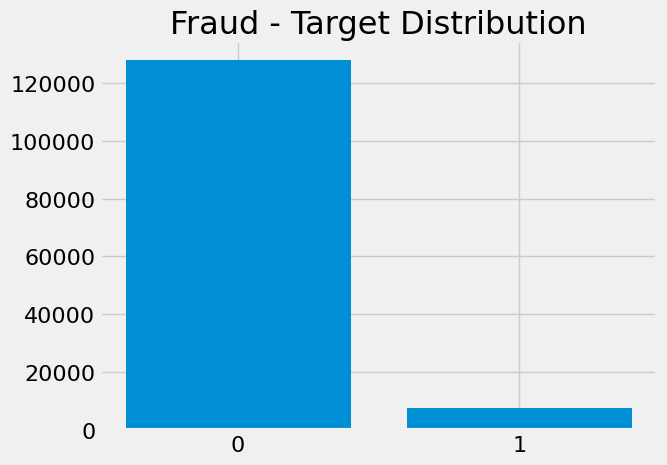

In [150]:
#Visualize fraudulent activities
fraudactivities = client_train.groupby(['target'])['client_id'].count()
plt.bar(x=fraudactivities.index, height=fraudactivities.values, tick_label = [0,1])
plt.title('Fraud - Target Distribution')
plt.show()

Target is highly imbalanced with fewer cases of fraudulent activities

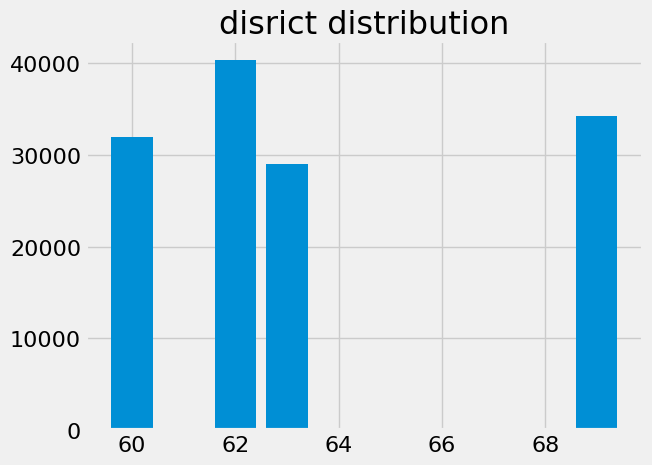

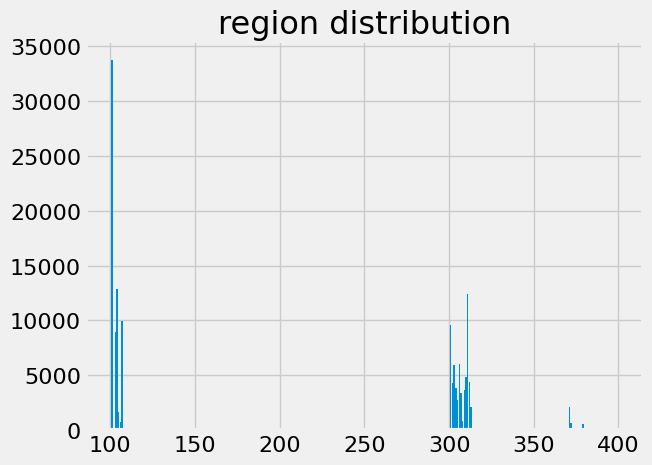

In [151]:
#Visualize client distribution across districts and regions
for col in ['disrict','region']:
    region = client_train.groupby([col])['client_id'].count()
    plt.bar(x=region.index, height=region.values)
    plt.title(col+' distribution')
    plt.show()

## Feature Engineering

In [152]:
#convert the column invoice_date to date time format on both the invoice train and invoice test
for df in [invoice_train,invoice_test]:
    df['invoice_date'] = pd.to_datetime(df['invoice_date'])

In [153]:
#encode labels in categorical column
d={"ELEC":0,"GAZ":1}
invoice_train['counter_type']=invoice_train['counter_type'].map(d)
invoice_test['counter_type']=invoice_test['counter_type'].map(d)

In [154]:
#convert categorical columns to int for model
client_train['client_catg'] = client_train['client_catg'].astype(int)
client_train['disrict'] = client_train['disrict'].astype(int)

client_test['client_catg'] = client_test['client_catg'].astype(int)
client_test['disrict'] = client_test['disrict'].astype(int)

In [155]:
def aggregate_by_client_id(invoice_data):
    aggs = {}
    aggs['consommation_level_1'] = ['mean']
    aggs['consommation_level_2'] = ['mean']
    aggs['consommation_level_3'] = ['mean']
    aggs['consommation_level_4'] = ['mean']

    agg_trans = invoice_data.groupby(['client_id']).agg(aggs)
    agg_trans.columns = ['_'.join(col).strip() for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace=True)

    df = (invoice_data.groupby('client_id')
            .size()
            .reset_index(name='{}transactions_count'.format('1')))
    return pd.merge(df, agg_trans, on='client_id', how='left')

In [156]:
#group invoice data by client_id
agg_train = aggregate_by_client_id(invoice_train)

In [157]:
print(agg_train.shape)
agg_train.head()

(135493, 6)


,client_id,1transactions_count,consommation_level_1_mean,consommation_level_2_mean,consommation_level_3_mean,consommation_level_4_mean
0,train_Client_0,35,352.400000,10.571429,0.000000,0.000000
1,train_Client_1,37,557.540541,0.000000,0.000000,0.000000
2,train_Client_10,18,798.611111,37.888889,0.000000,0.000000
3,train_Client_100,20,1.200000,0.000000,0.000000,0.000000
4,train_Client_1000,14,663.714286,104.857143,117.357143,36.714286


In [158]:
#merge aggregate data with client dataset
train = pd.merge(client_train,agg_train, on='client_id', how='left')

In [159]:
#aggregate test set
agg_test = aggregate_by_client_id(invoice_test)
test = pd.merge(client_test,agg_test, on='client_id', how='left')

In [160]:
train.shape, test.shape

((135493, 11), (58069, 10))

In [161]:
#drop redundant columns
sub_client_id = test['client_id']
drop_columns = ['client_id', 'creation_date']

for col in drop_columns:
    if col in train.columns:
        train.drop([col], axis=1, inplace=True)
    if col in test.columns:
        test.drop([col], axis=1, inplace=True)

In [162]:
train.shape, test.shape

((135493, 9), (58069, 8))

In [163]:
train.columns, test.columns

(Index(['disrict', 'client_catg', 'region', 'target', '1transactions_count',
        'consommation_level_1_mean', 'consommation_level_2_mean',
        'consommation_level_3_mean', 'consommation_level_4_mean'],
       dtype='object'),
 Index(['disrict', 'client_catg', 'region', '1transactions_count',
        'consommation_level_1_mean', 'consommation_level_2_mean',
        'consommation_level_3_mean', 'consommation_level_4_mean'],
       dtype='object'))

# Modelling

In [167]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.tree import plot_tree

## Pre-process data

* import required modules*

In [168]:
# Set random seed to ensure reproducible runs
RSEED = 50

In [169]:
train1 = pd.read_csv("data/df.csv")
train1.columns

Index(['client_id', 'transactions_count', 'consommation_level_1_mean',
       'consommation_level_2_mean', 'consommation_level_3_mean',
       'consommation_level_4_mean', 'months_number_max', 'months_number_min',
       'months_number_mean', 'consumption_sum', 'consumption_max',
       'consumption_min', 'consumption_mean', 'consumption_ave_max',
       'consumption_ave_min', 'consumption_ave_mean', 'month_0_count',
       'month_0_nunique', 'month_1_count', 'month_1_nunique', 'month_2_count',
       'month_2_nunique', 'month_3_count', 'month_3_nunique', 'month_4_count',
       'month_4_nunique', 'month_5_count', 'month_5_nunique', 'month_6_count',
       'month_6_nunique', 'month_7_count', 'month_7_nunique', 'month_8_count',
       'month_8_nunique', 'month_9_count', 'month_9_nunique', 'month_10_count',
       'month_10_nunique', 'month_11_count', 'month_11_nunique',
       'counter_statue_0_count', 'counter_statue_0_nunique',
       'counter_statue_1_count', 'counter_statue_1_nuniqu

In [191]:
#train = pd.read_csv("data/df.csv")
train = pd.read_csv("data/df2.csv")
# Features for feature importance
features = list(train.columns)
#train.head()

In [192]:

mask = train.columns[train.dtypes == "int"].tolist()
#train.columns
#mask

In [193]:
nan_check = train.isna().sum()
print(nan_check)

client_id                       0
target                          0
transactions_count            138
consommation_sum_max          138
consommation_sum_min          138
consommation_sum_mean         138
consommation_ave_max          138
consommation_ave_min          138
consommation_ave_mean         139
months_number_max             138
months_number_min             138
months_number_mean            138
consumption_sum               138
consumption_max               138
consumption_min               138
consumption_mean              138
consumption_ave_max           138
consumption_ave_min           138
consumption_ave_mean          138
month_0_count                 138
month_1_count                 138
month_2_count                 138
month_3_count                 138
month_4_count                 138
month_5_count                 138
month_6_count                 138
month_7_count                 138
month_8_count                 138
month_9_count                 138
month_10_count

In [194]:
train.dropna(inplace=True)  # This will remove rows with NaN values.
nan_check = train.isna().sum()
print(nan_check)

client_id                     0
target                        0
transactions_count            0
consommation_sum_max          0
consommation_sum_min          0
consommation_sum_mean         0
consommation_ave_max          0
consommation_ave_min          0
consommation_ave_mean         0
months_number_max             0
months_number_min             0
months_number_mean            0
consumption_sum               0
consumption_max               0
consumption_min               0
consumption_mean              0
consumption_ave_max           0
consumption_ave_min           0
consumption_ave_mean          0
month_0_count                 0
month_1_count                 0
month_2_count                 0
month_3_count                 0
month_4_count                 0
month_5_count                 0
month_6_count                 0
month_7_count                 0
month_8_count                 0
month_9_count                 0
month_10_count                0
month_11_count                0
counter_

In [195]:
y = train['target']
X = train[mask]
X = train.drop(columns=['target', 'client_id'])
#X = train.drop(columns=['target', 'client_id', 'creation_date'])

y.shape, X.shape

((135354,), (135354, 48))

In [106]:
#df.fillna(0, inplace=True)  # Fill NaN values with zero.

### split first, than rebalance the X_train, y_train

In [196]:
X_train, X_test, y_train,  y_test = train_test_split(X, y,test_size = 0.3)
X_train.shape, y_train.shape
#X_train
#y_train

((94747, 48), (94747,))

In [108]:
#nan_check = df.isna().sum()
#print(nan_check)

In [109]:
'''
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

# Apply RandomOverSampler to balance the dataset
os =  RandomOverSampler()
X_res, y_res = os.fit_resample(X_train, y_train)
X_train = X_res
y_train = y_res

# New count after balancing -> {0: 900, 1: 900}
print('Resampled dataset shape {}'.format(Counter(y_res)))
'''


"\nfrom imblearn.over_sampling import RandomOverSampler\nfrom collections import Counter\n\n# Apply RandomOverSampler to balance the dataset\nos =  RandomOverSampler()\nX_res, y_res = os.fit_resample(X_train, y_train)\nX_train = X_res\ny_train = y_res\n\n# New count after balancing -> {0: 900, 1: 900}\nprint('Resampled dataset shape {}'.format(Counter(y_res)))\n"

In [197]:

#pip install imbalanced-learn
from imblearn.over_sampling import SMOTE

sm = SMOTE(sampling_strategy='auto', random_state= 12)
X_res, y_res = sm.fit_resample(X_train, y_train)
X_train = X_res
y_train = y_res

# New count after balancing -> {0: 900, 1: 900}
print('Resampled dataset shape {}'.format(Counter(y_res)))


Resampled dataset shape Counter({0.0: 89443, 1.0: 89443})


In [198]:
unique, count = np.unique(y_train, return_counts=True)
y_trin_vdict_smote= {k:v for (k, v ) in zip (unique, count)}
y_trin_vdict_smote

{0.0: 89443, 1.0: 89443}

In [199]:
#Import the algorithms: 

import time
from sklearn import svm, tree, metrics
from sklearn.metrics import accuracy_score, log_loss

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.metrics import auc
#from sklearn.metrics import plot_roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold

## GradientBoostingClassifier

--------------------------------------------------------------------------------
GRADIENT BOOSTING CLASS
Train ROC AUC Score: 0.9397161903376441
Test ROC AUC  Score: 0.7095193297241649
--------------------------------------------------------------------------------
Confusion Matrix (Normalized): 
 [[0.84796328 0.15203672]
 [0.67138434 0.32861566]]
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Baseline ROC AUC: 0.5
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.96      0.85      0.90     38346
         1.0       0.11      0.33      0.17      2261

    accuracy                           0.82     40607
   macro avg       0.53      0.59      0.53     40607
weighted avg       0.91      0.82      0.86     40607

----------------------------------------------------------

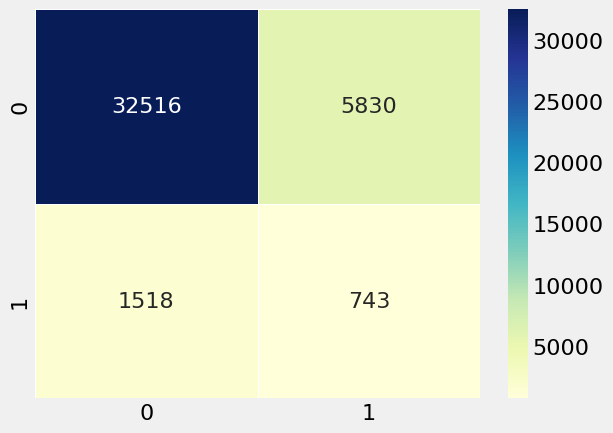

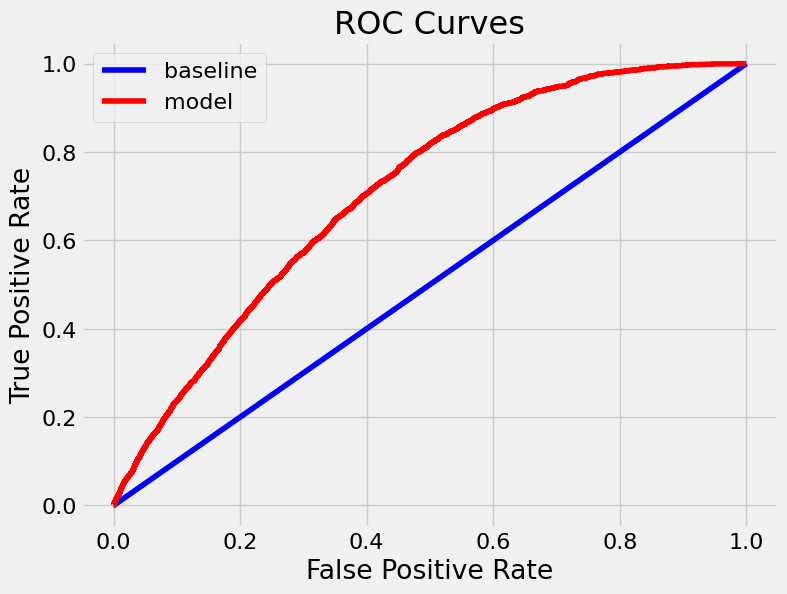

In [200]:



from sklearn.neighbors import KNeighborsClassifier
knn = GradientBoostingClassifier(max_depth=4, min_samples_split=2, min_samples_leaf=1, subsample=1,
                               max_features='sqrt', random_state=10)

knn.fit(X_train, np.ravel(y_train))

y_pred_knn = knn.predict(X_test)

#sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='YlGn');

model = knn
y_pred = y_pred_knn

# Make probability predictions
X_train_probs = model.predict_proba(X_train)[:, 1]
X_test_probs = model.predict_proba(X_test)[:, 1]

X_train_predictions = model.predict(X_train)


print("--------"*10)
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

print("GRADIENT BOOSTING CLASS")
print(f'Train ROC AUC Score: {roc_auc_score(y_train, X_train_probs)}')
print(f'Test ROC AUC  Score: {roc_auc_score(y_test, X_test_probs)}')
print("--------"*10)
print('Confusion Matrix (Normalized): \n', confusion_matrix(y_test, y_pred, normalize='true'))
print("--------"*10)
print("--------"*10)
print(f'Baseline ROC AUC: {roc_auc_score(y_test, [1 for _ in range(len(y_test))])}')
print("--------"*10)
# Print classification report of our model
print(classification_report(y_test, y_pred))
print("--------"*10)

# Evaluate the model with a confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5);


from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

print("--------"*10)
# Plot formatting
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18

# Calculate false positive rates and true positive rates
base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
model_fpr, model_tpr, _ = roc_curve(y_test, X_test_probs)

plt.figure(figsize = (8, 6))
plt.rcParams['font.size'] = 16
    
# Plot both curves
plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
plt.plot(model_fpr, model_tpr, 'r', label = 'model')
plt.legend()
plt.xlabel('False Positive Rate'); 
plt.ylabel('True Positive Rate'); plt.title('ROC Curves')
plt.show()


## Classifier: single decision treee

*define classifier*

In [112]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth = 15, random_state=RSEED)

*fit the model*

In [113]:
tree.fit(X_train, y_train)

print(f'Model Accuracy: {tree.score(X_train, y_train)}')
#print(f'Model Accuracy: {tree.score(X_test, y_test)}')
print(f'Decision tree has {tree.tree_.node_count} nodes with maximum depth {tree.tree_.max_depth}.')

Model Accuracy: 0.9110498103156929
Decision tree has 4675 nodes with maximum depth 15.


*plot the tree*

In [118]:
# Plot desision tree
#fig = plt.figure(figsize=(25,10))
#dectree_plot = plot_tree(tree, filled=True)

*predict*

In [114]:
y_pred_dt = tree.predict(X_test) # y_pred_dt = train_predictions - TODO adjust all containing train_predictions

*assess decision tree performance*

In [ ]:
# Make probability predictions
X_train_probs_dt = tree.predict_proba(X_train)[:, 1]
X_test_probs_dt = tree.predict_proba(X_test)[:, 1]

X_train_predictions_dt = tree.predict(X_train)

from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

print(f'Train ROC AUC Score: {roc_auc_score(y_train, X_train_probs_dt)}')
print(f'Test ROC AUC  Score: {roc_auc_score(y_test, X_test_probs_dt)}')
print("--------"*10)
print(f'Baseline ROC AUC: {roc_auc_score(y_test, [1 for _ in range(len(y_test))])}')
print("--------"*10)
# Print classification report of our model
print(classification_report(y_test, y_pred_dt))
print("--------"*10)

# Evaluate the model with a confusion matrix
cm_dt = confusion_matrix(y_test, y_pred_dt)
sns.heatmap(cm_dt, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5);

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

print("--------"*10)
# Plot formatting
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18

# Calculate false positive rates and true positive rates
base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
model_fpr, model_tpr, _ = roc_curve(y_test, X_test_probs_dt)

plt.figure(figsize = (8, 6))
plt.rcParams['font.size'] = 16
    
# Plot both curves
plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
plt.plot(model_fpr, model_tpr, 'r', label = 'model')
plt.legend()
plt.xlabel('False Positive Rate'); 
plt.ylabel('True Positive Rate'); plt.title('ROC Curves')
plt.show()


## Classifier: forest

*classifier*

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Create the model with 100 trees
rdfo = RandomForestClassifier(n_estimators=100, 
                               random_state=RSEED, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1)

# Fit on training data
rdfo.fit(X_train, y_train)

# predict
y_pred_rdfo = rdfo.predict(X_test)

*assess*

In [ ]:
# adjust variables
model = rdfo
y_pred = y_pred_rdfo

# Make probability predictions
X_train_probs = model.predict_proba(X_train)[:, 1]
X_test_probs = model.predict_proba(X_test)[:, 1]

X_train_predictions = model.predict(X_train)

from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

print(f'Train ROC AUC Score: {roc_auc_score(y_train, X_train_probs)}')
print(f'Test ROC AUC  Score: {roc_auc_score(y_test, X_test_probs)}')
print("--------"*10)
print(f'Baseline ROC AUC: {roc_auc_score(y_test, [1 for _ in range(len(y_test))])}')
print("--------"*10)
# Print classification report of our model
print(classification_report(y_test, y_pred))
print("--------"*10)

# Evaluate the model with a confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5);


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

print("--------"*10)
# Plot formatting
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18

# Calculate false positive rates and true positive rates
base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
model_fpr, model_tpr, _ = roc_curve(y_test, X_test_probs)

plt.figure(figsize = (8, 6))
plt.rcParams['font.size'] = 16
    
# Plot both curves
plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
plt.plot(model_fpr, model_tpr, 'r', label = 'model')
plt.legend()
plt.xlabel('False Positive Rate'); 
plt.ylabel('True Positive Rate'); plt.title('ROC Curves')
plt.show()

## Classifier: LGBM 

The LGBMClassifier is a classifier based on the LightGBM gradient boosting framework. LightGBM is a powerful and efficient gradient boosting library designed for speed and performance.

In [ ]:
'''
cm_rdfo = confusion_matrix(y_test, y_pred_rdfo)
sns.heatmap(cm_rdfo, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5);

model_lgbm = LGBMClassifier(boosting_type='gbdt', num_iterationss=500)

model_lgbm.fit(X_train, y_train)

y_pred_lgbm = model_lgbm.predict(X_test)
#y_pred_lgbm = pd.DataFrame(y_pred_lgbm, columns=['target'])
#y_pred_lgbm.head()

cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)
sns.heatmap(cm_lgbm, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5);
'''

## Classifier KNN

In [ ]:
'''
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')

knn.fit(X_train, np.ravel(y_train))

y_pred_knn = knn.predict(X_test)

#sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='YlGn');

model = knn
y_pred = y_pred_knn

# Make probability predictions
X_train_probs = model.predict_proba(X_train)[:, 1]
X_test_probs = model.predict_proba(X_test)[:, 1]

X_train_predictions = model.predict(X_train)


print("--------"*10)
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

print(f'Train ROC AUC Score: {roc_auc_score(y_train, X_train_probs)}')
print(f'Test ROC AUC  Score: {roc_auc_score(y_test, X_test_probs)}')
print("--------"*10)
print(f'Baseline ROC AUC: {roc_auc_score(y_test, [1 for _ in range(len(y_test))])}')
print("--------"*10)
# Print classification report of our model
print(classification_report(y_test, y_pred))
print("--------"*10)

# Evaluate the model with a confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5);


from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

print("--------"*10)
# Plot formatting
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18

# Calculate false positive rates and true positive rates
base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
model_fpr, model_tpr, _ = roc_curve(y_test, X_test_probs)

plt.figure(figsize = (8, 6))
plt.rcParams['font.size'] = 16
    
# Plot both curves
plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
plt.plot(model_fpr, model_tpr, 'r', label = 'model')
plt.legend()
plt.xlabel('False Positive Rate'); 
plt.ylabel('True Positive Rate'); plt.title('ROC Curves')
plt.show()
'''

## gradient boosting 

In [202]:
# random forrest Decision Tree
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

param_grid_gbc = {
    'max_depth': [4,10, 15], 
    'min_samples_split': [2], 
    'min_samples_leaf': [1], 
    'subsample': [1], 
    'max_features': ['sprt'], 
    }

# cf = classifier(n_estimators=100, max_depth=10, class_weight='balanced', random_state=42)

classifier_gbc = GradientBoostingClassifier()

In [210]:
classifier_gbc.get_params()
X_train.shape, y_train.shape

((178886, 48), (178886,))

### random search gradiend boosting

Fitting 8 folds for each of 3 candidates, totalling 24 fits


[CV 7/8] END max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, subsample=1;, score=0.955 total time= 1.5min
[CV 6/8] END max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, subsample=1;, score=0.950 total time= 1.5min
[CV 3/8] END max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, subsample=1;, score=0.950 total time= 1.5min
[CV 5/8] END max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, subsample=1;, score=0.949 total time= 1.5min
[CV 8/8] END max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, subsample=1;, score=0.951 total time= 1.5min
[CV 4/8] END max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, subsample=1;, score=0.953 total time= 1.5min
[CV 2/8] END max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, subsample=1;, score=0.952 total time= 1.5min
[CV 1/8] END max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=

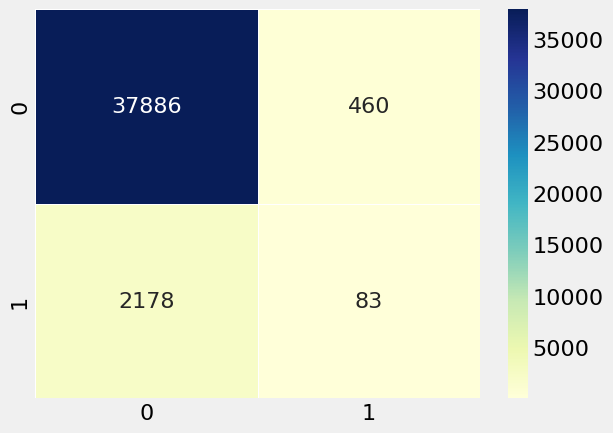

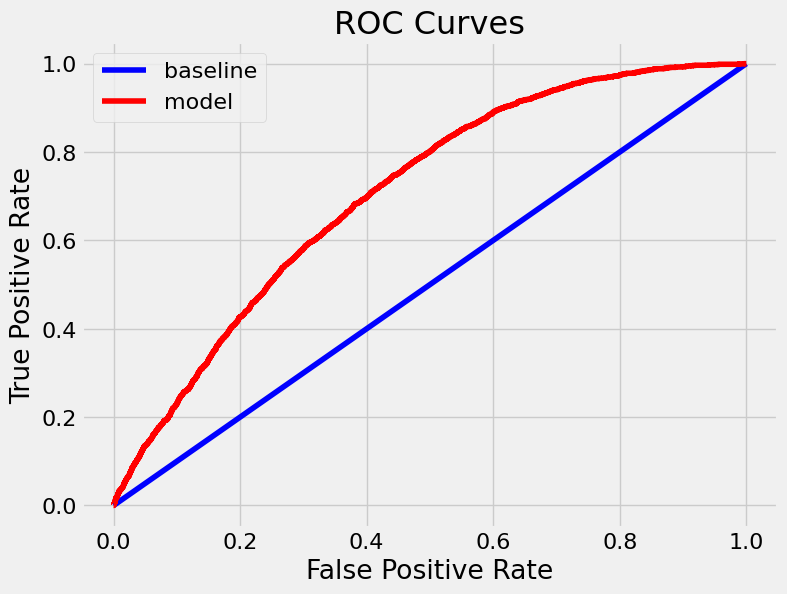

In [211]:

# random forrest Decision Tree
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

param_grid_gbc = {
    'max_depth': [4,10, 15], 
    'min_samples_split': [2], 
    'min_samples_leaf': [1], 
    'subsample': [1], 
    'max_features': ['sqrt']
    }

# cf = classifier(n_estimators=100, max_depth=10, class_weight='balanced', random_state=42)

classifier_gbc = GradientBoostingClassifier()

classifier = classifier_gbc
param_grid = param_grid_gbc

rs = RandomizedSearchCV(classifier, param_grid, n_jobs = -1, 
                        scoring = 'roc_auc', cv = 8,
                        n_iter = 10, verbose = 5, random_state=42)

rs.fit(X_train, y_train)


# classsifier
print("~" * 21)
print('for classifier: DecisionTreeClassifier()')
# Best score
print('Best score:', round(rs.best_score_, 3))
# Best parameters
print('Best parameters:', rs.best_params_)
print("~" * 21)
print()

best_model = rs.best_estimator_

y_pred_rs = best_model.predict(X_test)


# statistics output
cm_rs = confusion_matrix(y_test, y_pred_rs)
cm = cm_rs
model = best_model
y_pred = y_pred_rs

# Make probability predictions
X_train_probs = model.predict_proba(X_train)[:, 1]
X_test_probs = model.predict_proba(X_test)[:, 1]

X_train_predictions = model.predict(X_train)

from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
'''
print("--------"*10)
y_test, y_pred, y_pred_proba = modelling(df, cl)
evaluate_input_list = ['lgbm', y_test, y_pred, y_pred_proba]
evaluating(evaluate_input_list)
print("--------"*10)
'''
print(f'Train ROC AUC Score: {roc_auc_score(y_train, X_train_probs)}')
print(f'Test ROC AUC  Score: {roc_auc_score(y_test, X_test_probs)}')
print("--------"*10)
print(f'Baseline ROC AUC: {roc_auc_score(y_test, [1 for _ in range(len(y_test))])}')
print("--------"*10)
# Print classification report of our model
print(classification_report(y_test, y_pred))
print("--------"*10)

# Evaluate the model with a confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5);


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

print("--------"*10)
# Plot formatting
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18

# Calculate false positive rates and true positive rates
base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
model_fpr, model_tpr, _ = roc_curve(y_test, X_test_probs)

plt.figure(figsize = (8, 6))
plt.rcParams['font.size'] = 16
    
# Plot both curves
plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
plt.plot(model_fpr, model_tpr, 'r', label = 'model')
plt.legend()
plt.xlabel('False Positive Rate'); 
plt.ylabel('True Positive Rate'); plt.title('ROC Curves')
plt.show()

### grid search gradient boosting classifier

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 4/5] END max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, subsample=1;, score=0.988 total time= 4.0min
[CV 5/5] END max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, subsample=1;, score=0.988 total time= 4.0min
[CV 2/5] END max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, subsample=1;, score=0.990 total time= 4.0min
[CV 3/5] END max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, subsample=1;, score=0.989 total time= 4.0min
[CV 1/5] END max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, subsample=1;, score=0.854 total time= 4.0min
~~~~~~~~~~~~~~~~~~~~~
for classifier: DecisionTreeClassifier()
Best score: 0.962
Best parameters: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'subsample': 1}
~~~~~~~~~~~~~~~~~~~~~

Train ROC AUC Score: 0.9998076145833968
Test ROC AUC  S

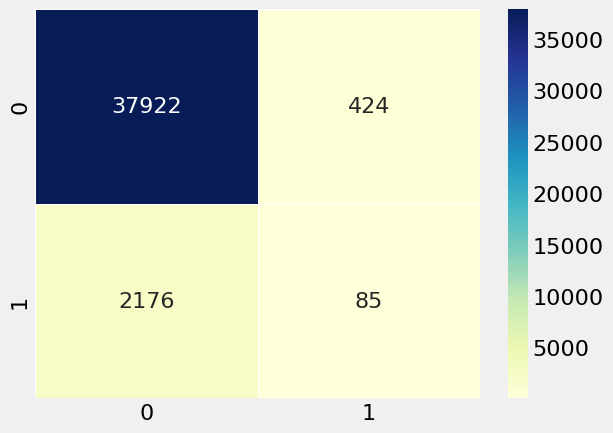

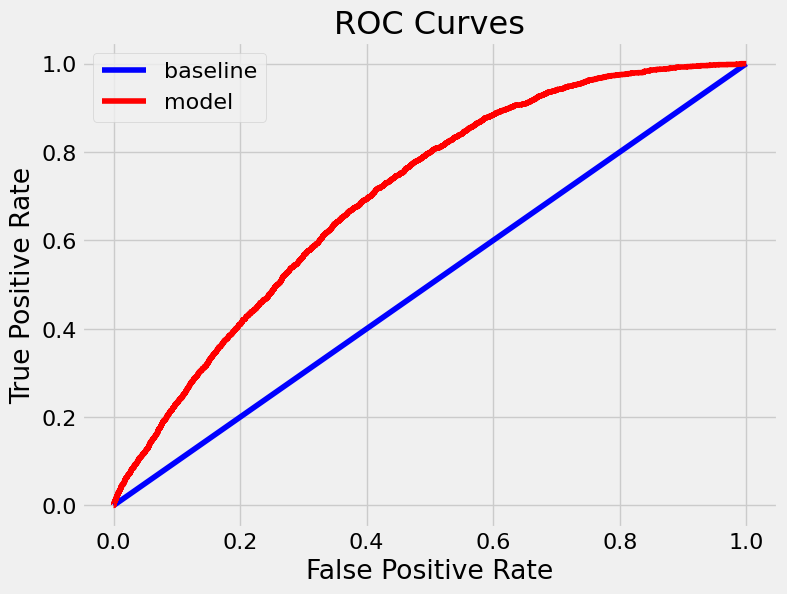

In [212]:
# random forrest Decision Tree
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

#Best parameters: {'subsample': 1, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 15}

param_grid_gbc = {
    'max_depth': [15], 
    'min_samples_split': [2], 
    'min_samples_leaf': [1], 
    'subsample': [1], 
    'max_features': ['sqrt']
    }

# cf = classifier(n_estimators=100, max_depth=10, class_weight='balanced', random_state=42)

classifier_gbc = GradientBoostingClassifier()

classifier = classifier_gbc
param_grid = param_grid_gbc

gs = GridSearchCV(
    estimator=classifier,
    param_grid=param_grid,
    scoring="accuracy",
    n_jobs=-1,
    cv=5,
    verbose=5
)

gs.fit(X_train, y_train)


# classsifier
print("~" * 21)
print('for classifier: DecisionTreeClassifier()')
# Best score
print('Best score:', round(gs.best_score_, 3))
# Best parameters
print('Best parameters:', gs.best_params_)
print("~" * 21)
print()

best_model = gs.best_estimator_

y_pred_gs = best_model.predict(X_test)


# statistics output
cm_gs = confusion_matrix(y_test, y_pred_gs)
cm = cm_gs
model = best_model
y_pred = y_pred_gs

# Make probability predictions
X_train_probs = model.predict_proba(X_train)[:, 1]
X_test_probs = model.predict_proba(X_test)[:, 1]

X_train_predictions = model.predict(X_train)

from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

'''
#TODO dont work
print("--------"*10)
y_test, y_pred, y_pred_proba = modelling(df, 'lgbm')
evaluate_input_list = ['lgbm', y_test, y_pred, y_pred_proba]
evaluating(evaluate_input_list)
print("--------"*10)
'''

print(f'Train ROC AUC Score: {roc_auc_score(y_train, X_train_probs)}')
print(f'Test ROC AUC  Score: {roc_auc_score(y_test, X_test_probs)}')
print("--------"*10)
print('Confusion Matrix (Normalized): \n', confusion_matrix(y_test, y_pred_gs, normalize='true'))
print("--------"*10)
print(f'Baseline ROC AUC: {roc_auc_score(y_test, [1 for _ in range(len(y_test))])}')
print("--------"*10)
# Print classification report of our model
print(classification_report(y_test, y_pred))
print("--------"*10)

# Evaluate the model with a confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5);


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

print("--------"*10)
# Plot formatting
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18

# Calculate false positive rates and true positive rates
base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
model_fpr, model_tpr, _ = roc_curve(y_test, X_test_probs)

plt.figure(figsize = (8, 6))
plt.rcParams['font.size'] = 16
    
# Plot both curves
plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
plt.plot(model_fpr, model_tpr, 'r', label = 'model')
plt.legend()
plt.xlabel('False Positive Rate'); 
plt.ylabel('True Positive Rate'); plt.title('ROC Curves')
plt.show()

## Grid Search

In [ ]:
'''
from sklearn.model_selection import GridSearchCV
# Define parameter grid for randomized search
'''
param_grid = {"n_neighbors" : [2,4,3,5,10], #this actually defines the model you use
              "weights" : ["uniform", "distance"],
              "p" : [1, 2, 3],
              "algorithm": ["ball_tree", "kd_tree", "brute"]
             }
'''


param_grid = {
    'criterion': ['gini', 'entropy'],  # Split criterion (default: 'gini')
    'splitter': ['best', 'random'],   # Strategy to choose the split at each node (default: 'best')
    'max_depth': list(range(1, 21)), # Maximum depth of the tree (default: None)
    'min_samples_split': list(range(2, 10, 2)),  # Minimum number of samples required to split an internal node (default: 2)
    'min_samples_leaf': [1, 2, 4],   # Minimum number of samples required to be at a leaf node (default: 1)
    'max_features': [None, 'auto', 'sqrt', 'log2'],  # Number of features to consider when looking for the best split (default: None)
    'random_state': [RSEED]  # Seed for random number generator (default: None)
}
#DecisionTreeClassifier(max_depth = 15, random_state=RSEED)
#DecisionTreeClassifier(criterion='gini', max_depth= 50, min_samples_leaf=5, min_samples_split=10),

gs = GridSearchCV(
    #estimator=KNeighborsClassifier(), 
    estimator=DecisionTreeClassifier(),
    param_grid=param_grid,
    scoring="accuracy",
    n_jobs=-1,
    cv=5,
    verbose=5
)

gs.fit(X_train, y_train)

# Best score
print('Best score:', round(gs.best_score_, 3))

# Best parameters
print('Best parameters:', gs.best_params_)
'''

## Random Search

*classifier & estimator*

In [188]:
#Import the algorithms: 

import time
from sklearn import svm, tree, metrics
from sklearn.metrics import accuracy_score, log_loss

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.metrics import auc
#from sklearn.metrics import plot_roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold

Fitting 8 folds for each of 10 candidates, totalling 80 fits
[CV 7/8] END criterion=gini, max_depth=44, max_features=log2, min_samples_leaf=1, min_samples_split=2, random_state=50, splitter=best;, score=0.935 total time=   8.8s
[CV 1/8] END criterion=gini, max_depth=44, max_features=log2, min_samples_leaf=1, min_samples_split=2, random_state=50, splitter=best;, score=0.783 total time=   8.9s
[CV 6/8] END criterion=gini, max_depth=44, max_features=log2, min_samples_leaf=1, min_samples_split=2, random_state=50, splitter=best;, score=0.919 total time=   8.8s
[CV 2/8] END criterion=gini, max_depth=44, max_features=log2, min_samples_leaf=1, min_samples_split=2, random_state=50, splitter=best;, score=0.926 total time=   8.9s
[CV 5/8] END criterion=gini, max_depth=44, max_features=log2, min_samples_leaf=1, min_samples_split=2, random_state=50, splitter=best;, score=0.919 total time=   9.1s
[CV 8/8] END criterion=gini, max_depth=44, max_features=log2, min_samples_leaf=1, min_samples_split=2, r

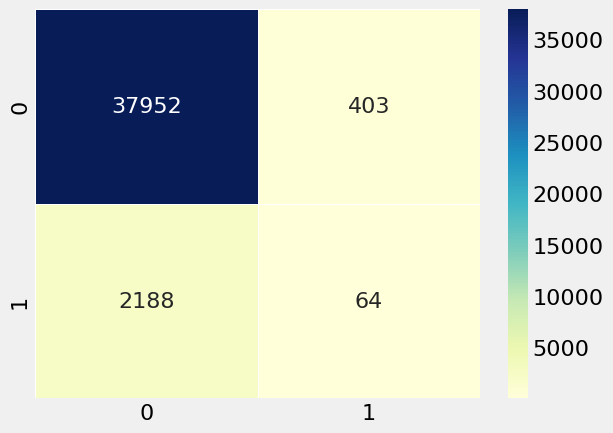

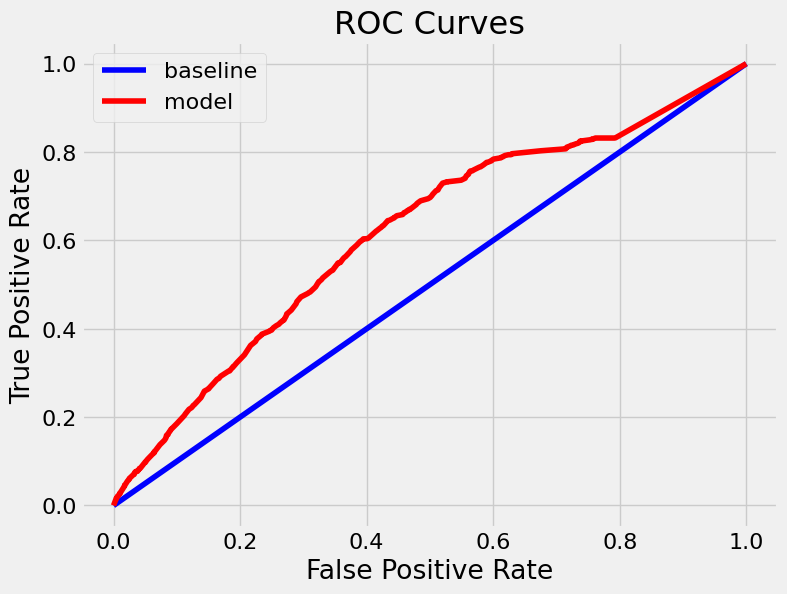

In [189]:
# random forrest Decision Tree
from sklearn.model_selection import RandomizedSearchCV


param_grid_dtc = {
    'criterion': ['gini', 'entropy'],  # Split criterion (default: 'gini')
    'splitter': ['best', 'random'],   # Strategy to choose the split at each node (default: 'best')
    'max_depth': list(range(1, 50)), # Maximum depth of the tree (default: None)
    'min_samples_split': list(range(2, 10, 2)),  # Minimum number of samples required to split an internal node (default: 2)
    'min_samples_leaf': [1, 2, 4, 10],   # Minimum number of samples required to be at a leaf node (default: 1)
    'max_features': [None, 'auto', 'sqrt', 'log2'],  # Number of features to consider when looking for the best split (default: None)
    'random_state': [RSEED]  # Seed for random number generator (default: None)
}
'''
# Hyperparameter grid for forest
param_grid_rfc = {
    'n_estimators': list(range(10, 100, 10)),
    'max_depth': list(range(1, 21)),
    'max_features': ['auto', 'sqrt', None],
    #'max_leaf_nodes': list(range(10, 51)),
    #'min_samples_split': list(range(2, 11, 2)),
    'bootstrap': [True, False]
}

#Logistic Regression param grid
param_grid_lr = {
    'penalty': ['l1', 'l2'],  # Regularization penalty (L1 or L2)
    'C': [0.001, 0.01, 0.1, 1.0, 10.0],  # Inverse of regularization strength
    'solver': ['liblinear', 'lbfgs', 'saga'],  # Algorithm to use for optimization
    'max_iter': [100, 200, 300]  # Maximum number of iterations for optimization
}

param_grid_lda = {
    'solver': ['svd', 'lsqr', 'eigen'],  # Solver to use (default: 'svd')
    'shrinkage': [None, 'auto', 0.1, 0.5, 1.0],  # Shrinkage parameter (default: None)
    'n_components': [None, 1, 2, 3],  # Number of components for dimensionality reduction (default: None)
    'store_covariance': [False, True]  # Whether to store covariance matrices (default: False)
}

param_grid_gbc = {
    'n_estimators': [100, 200, 300],          # Number of boosting stages to be used (default: 100)
    'learning_rate': [0.01, 0.1, 0.2],       # Step size shrinkage used in update to prevent overfitting (default: 0.1)
    'max_depth': [3, 4, 5],                 # Maximum depth of individual trees (default: 3)
    'min_samples_split': [2, 3, 4],         # Minimum number of samples required to split an internal node (default: 2)
    'min_samples_leaf': [1, 2, 3],          # Minimum number of samples required to be at a leaf node (default: 1)
    'subsample': [0.8, 0.9, 1.0],           # Fraction of samples used for fitting the trees (default: 1.0)
    'random_state': [RSEED]                 # Random seed for reproducibility
}
'''

# Estimator for use in random search
clasifier_dtc =  DecisionTreeClassifier(random_state = RSEED)
#clasifier_rfc = RandomForestClassifier(random_state = RSEED)
#clasifier_lr = LogisticRegression(random_state = RSEED)
#clasifier_lda = LinearDiscriminantAnalysis()
#clasifier_gbc = GradientBoostingClassifier(random_state = RSEED)

# Create the random search model
#for estimator in clasifier_set:
rs = RandomizedSearchCV(clasifier_dtc, param_grid_dtc, n_jobs = -1, 
                        scoring = 'roc_auc', cv = 8,
                        n_iter = 10, verbose = 5, random_state=RSEED)

rs.fit(X_train, y_train)

# classsifier
print("~" * 21)
print('for classifier: DecisionTreeClassifier()')
# Best score
print('Best score:', round(rs.best_score_, 3))
# Best parameters
print('Best parameters:', rs.best_params_)
print("~" * 21)
print()

best_model = rs.best_estimator_

y_pred_rs = best_model.predict(X_test)


# statistics output
cm_rs = confusion_matrix(y_test, y_pred_rs)
cm = cm_rs
model = best_model
y_pred = y_pred_rs

# Make probability predictions
X_train_probs = model.predict_proba(X_train)[:, 1]
X_test_probs = model.predict_proba(X_test)[:, 1]

X_train_predictions = model.predict(X_train)

from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

print(f'Train ROC AUC Score: {roc_auc_score(y_train, X_train_probs)}')
print(f'Test ROC AUC  Score: {roc_auc_score(y_test, X_test_probs)}')
print("--------"*10)
print(f'Baseline ROC AUC: {roc_auc_score(y_test, [1 for _ in range(len(y_test))])}')
print("--------"*10)
# Print classification report of our model
print(classification_report(y_test, y_pred))
print("--------"*10)

# Evaluate the model with a confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5);


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

print("--------"*10)
# Plot formatting
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18

# Calculate false positive rates and true positive rates
base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
model_fpr, model_tpr, _ = roc_curve(y_test, X_test_probs)

plt.figure(figsize = (8, 6))
plt.rcParams['font.size'] = 16
    
# Plot both curves
plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
plt.plot(model_fpr, model_tpr, 'r', label = 'model')
plt.legend()
plt.xlabel('False Positive Rate'); 
plt.ylabel('True Positive Rate'); plt.title('ROC Curves')
plt.show()

In [ ]:
# random forest RSCV
from sklearn.model_selection import RandomizedSearchCV

'''
param_grid_dtc = {
    'criterion': ['gini', 'entropy'],  # Split criterion (default: 'gini')
    'splitter': ['best', 'random'],   # Strategy to choose the split at each node (default: 'best')
    'max_depth': list(range(1, 50)), # Maximum depth of the tree (default: None)
    'min_samples_split': list(range(2, 10, 2)),  # Minimum number of samples required to split an internal node (default: 2)
    'min_samples_leaf': [1, 2, 4, 10],   # Minimum number of samples required to be at a leaf node (default: 1)
    'max_features': [None, 'auto', 'sqrt', 'log2'],  # Number of features to consider when looking for the best split (default: None)
    'random_state': [RSEED]  # Seed for random number generator (default: None)
}
'''
# Hyperparameter grid for forest
param_grid_rfc = {
    'n_estimators': list(range(10, 100, 10)),
    'max_depth': list(range(1, 21)),
    'max_features': ['auto', 'sqrt', None],
    'criterion' : ['entropy'],
    #'max_leaf_nodes': list(range(10, 51)),
    #'min_samples_split': list(range(2, 11, 2)),
    'bootstrap': [True, False]
}

'''

#Logistic Regression param grid
param_grid_lr = {
    'penalty': ['l1', 'l2'],  # Regularization penalty (L1 or L2)
    'C': [0.001, 0.01, 0.1, 1.0, 10.0],  # Inverse of regularization strength
    'solver': ['liblinear', 'lbfgs', 'saga'],  # Algorithm to use for optimization
    'max_iter': [100, 200, 300]  # Maximum number of iterations for optimization
}

param_grid_lda = {
    'solver': ['svd', 'lsqr', 'eigen'],  # Solver to use (default: 'svd')
    'shrinkage': [None, 'auto', 0.1, 0.5, 1.0],  # Shrinkage parameter (default: None)
    'n_components': [None, 1, 2, 3],  # Number of components for dimensionality reduction (default: None)
    'store_covariance': [False, True]  # Whether to store covariance matrices (default: False)
}

param_grid_gbc = {
    'n_estimators': [100, 200, 300],          # Number of boosting stages to be used (default: 100)
    'learning_rate': [0.01, 0.1, 0.2],       # Step size shrinkage used in update to prevent overfitting (default: 0.1)
    'max_depth': [3, 4, 5],                 # Maximum depth of individual trees (default: 3)
    'min_samples_split': [2, 3, 4],         # Minimum number of samples required to split an internal node (default: 2)
    'min_samples_leaf': [1, 2, 3],          # Minimum number of samples required to be at a leaf node (default: 1)
    'subsample': [0.8, 0.9, 1.0],           # Fraction of samples used for fitting the trees (default: 1.0)
    'random_state': [RSEED]                 # Random seed for reproducibility
}
'''

# Estimator for use in random search
#clasifier_dtc =  DecisionTreeClassifier(random_state = RSEED)
clasifier_rfc = RandomForestClassifier(random_state = RSEED)
#clasifier_lr = LogisticRegression(random_state = RSEED)
#clasifier_lda = LinearDiscriminantAnalysis()
#clasifier_gbc = GradientBoostingClassifier(random_state = RSEED)

# Create the random search model
#for estimator in clasifier_set:
rs = RandomizedSearchCV(clasifier_rfc, param_grid_rfc, n_jobs = -1, 
                        scoring = 'roc_auc', cv = 8,
                        n_iter = 10, verbose = 5, random_state=RSEED)

rs.fit(X_train, y_train)

# classsifier
print("~" * 21)
print('for classifier: RandomForeestClassifier()')
# Best score
print('Best score:', round(rs.best_score_, 3))
# Best parameters
print('Best parameters:', rs.best_params_)
print("~" * 21)
print()

best_model = rs.best_estimator_

y_pred_rs = best_model.predict(X_test)


# statistics output
cm_rs = confusion_matrix(y_test, y_pred_rs)
cm = cm_rs
model = best_model
y_pred = y_pred_rs

# Make probability predictions
X_train_probs = model.predict_proba(X_train)[:, 1]
X_test_probs = model.predict_proba(X_test)[:, 1]

X_train_predictions = model.predict(X_train)

from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

print(f'Train ROC AUC Score: {roc_auc_score(y_train, X_train_probs)}')
print(f'Test ROC AUC  Score: {roc_auc_score(y_test, X_test_probs)}')
print("--------"*10)
print(f'Baseline ROC AUC: {roc_auc_score(y_test, [1 for _ in range(len(y_test))])}')
print("--------"*10)
# Print classification report of our model
print(classification_report(y_test, y_pred))
print("--------"*10)

# Evaluate the model with a confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5);


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

print("--------"*10)
# Plot formatting
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18

# Calculate false positive rates and true positive rates
base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
model_fpr, model_tpr, _ = roc_curve(y_test, X_test_probs)

plt.figure(figsize = (8, 6))
plt.rcParams['font.size'] = 16
    
# Plot both curves
plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
plt.plot(model_fpr, model_tpr, 'r', label = 'model')
plt.legend()
plt.xlabel('False Positive Rate'); 
plt.ylabel('True Positive Rate'); plt.title('ROC Curves')
plt.show()

Fitting 8 folds for each of 10 candidates, totalling 80 fits
[CV 3/8] END C=0.1, max_iter=100, penalty=l1, solver=lbfgs;, score=nan total time=   0.2s
[CV 4/8] END C=0.1, max_iter=100, penalty=l1, solver=lbfgs;, score=nan total time=   0.2s
[CV 5/8] END C=0.1, max_iter=100, penalty=l1, solver=lbfgs;, score=nan total time=   0.2s
[CV 6/8] END C=0.1, max_iter=100, penalty=l1, solver=lbfgs;, score=nan total time=   0.3s
[CV 1/8] END C=0.1, max_iter=100, penalty=l1, solver=lbfgs;, score=nan total time=   0.3s
[CV 7/8] END C=0.1, max_iter=100, penalty=l1, solver=lbfgs;, score=nan total time=   0.3s
[CV 2/8] END C=0.1, max_iter=100, penalty=l1, solver=lbfgs;, score=nan total time=   0.4s
[CV 8/8] END C=0.1, max_iter=100, penalty=l1, solver=lbfgs;, score=nan total time=   0.4s
[CV 8/8] END C=0.01, max_iter=200, penalty=l1, solver=lbfgs;, score=nan total time=   0.2s
[CV 6/8] END C=0.01, max_iter=200, penalty=l1, solver=lbfgs;, score=nan total time=   0.3s
[CV 2/8] END C=0.01, max_iter=200, pe

/Users/wieslawgrzesik/Projects/Data Science Bootcamp/repositories/ML_project_fraud_detection/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/wieslawgrzesik/Projects/Data Science Bootcamp/repositories/ML_project_fraud_detection/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/wieslawgrzesik/Projects/Data Science Bootcamp/repositories/ML_project_fraud_detection/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/wieslawgrzesik/Projects/Data Science Bootcamp/repositories/ML_project_fraud_detection/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached whic

[CV 1/8] END C=0.001, max_iter=200, penalty=l1, solver=saga;, score=0.703 total time= 1.4min
[CV 3/8] END C=0.001, max_iter=200, penalty=l1, solver=saga;, score=0.698 total time= 1.4min
[CV 5/8] END C=0.001, max_iter=200, penalty=l1, solver=saga;, score=0.702 total time= 1.4min
[CV 2/8] END C=0.001, max_iter=200, penalty=l1, solver=saga;, score=0.703 total time= 1.4min


/Users/wieslawgrzesik/Projects/Data Science Bootcamp/repositories/ML_project_fraud_detection/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/wieslawgrzesik/Projects/Data Science Bootcamp/repositories/ML_project_fraud_detection/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/wieslawgrzesik/Projects/Data Science Bootcamp/repositories/ML_project_fraud_detection/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 6/8] END C=0.001, max_iter=200, penalty=l1, solver=saga;, score=0.707 total time= 1.4min
[CV 8/8] END C=0.001, max_iter=200, penalty=l1, solver=saga;, score=0.700 total time= 1.4min
[CV 4/8] END C=0.001, max_iter=200, penalty=l1, solver=saga;, score=0.698 total time= 1.4min


/Users/wieslawgrzesik/Projects/Data Science Bootcamp/repositories/ML_project_fraud_detection/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 7/8] END C=0.001, max_iter=200, penalty=l1, solver=saga;, score=0.700 total time= 1.7min
[CV 5/8] END C=1.0, max_iter=100, penalty=l1, solver=liblinear;, score=0.699 total time= 3.1min
[CV 8/8] END C=1.0, max_iter=100, penalty=l1, solver=liblinear;, score=0.698 total time= 3.1min
[CV 1/8] END C=1.0, max_iter=100, penalty=l1, solver=liblinear;, score=0.700 total time= 3.3min
[CV 3/8] END C=1.0, max_iter=100, penalty=l1, solver=liblinear;, score=0.693 total time= 3.6min
[CV 2/8] END C=1.0, max_iter=100, penalty=l1, solver=liblinear;, score=0.697 total time= 3.9min


/Users/wieslawgrzesik/Projects/Data Science Bootcamp/repositories/ML_project_fraud_detection/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/8] END C=0.1, max_iter=100, penalty=l1, solver=saga;, score=0.701 total time=  51.6s
[CV 7/8] END C=1.0, max_iter=100, penalty=l1, solver=liblinear;, score=0.692 total time= 4.1min
[CV 6/8] END C=1.0, max_iter=100, penalty=l1, solver=liblinear;, score=0.701 total time= 4.1min


/Users/wieslawgrzesik/Projects/Data Science Bootcamp/repositories/ML_project_fraud_detection/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/8] END C=0.1, max_iter=100, penalty=l1, solver=saga;, score=0.700 total time=  50.6s


/Users/wieslawgrzesik/Projects/Data Science Bootcamp/repositories/ML_project_fraud_detection/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/8] END C=0.1, max_iter=100, penalty=l1, solver=saga;, score=0.695 total time=  50.4s


/Users/wieslawgrzesik/Projects/Data Science Bootcamp/repositories/ML_project_fraud_detection/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/8] END C=0.1, max_iter=100, penalty=l1, solver=saga;, score=0.695 total time=  49.9s


/Users/wieslawgrzesik/Projects/Data Science Bootcamp/repositories/ML_project_fraud_detection/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/8] END C=0.001, max_iter=300, penalty=l2, solver=lbfgs;, score=0.695 total time=  19.3s


/Users/wieslawgrzesik/Projects/Data Science Bootcamp/repositories/ML_project_fraud_detection/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/8] END C=0.001, max_iter=300, penalty=l2, solver=lbfgs;, score=0.698 total time=  19.2s
[CV 4/8] END C=1.0, max_iter=100, penalty=l1, solver=liblinear;, score=0.698 total time= 4.6min


/Users/wieslawgrzesik/Projects/Data Science Bootcamp/repositories/ML_project_fraud_detection/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/8] END C=0.1, max_iter=100, penalty=l1, solver=saga;, score=0.700 total time=  51.0s


/Users/wieslawgrzesik/Projects/Data Science Bootcamp/repositories/ML_project_fraud_detection/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 6/8] END C=0.1, max_iter=100, penalty=l1, solver=saga;, score=0.705 total time=  51.6s


/Users/wieslawgrzesik/Projects/Data Science Bootcamp/repositories/ML_project_fraud_detection/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/8] END C=0.001, max_iter=300, penalty=l2, solver=lbfgs;, score=0.692 total time=  23.1s


/Users/wieslawgrzesik/Projects/Data Science Bootcamp/repositories/ML_project_fraud_detection/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/8] END C=0.001, max_iter=300, penalty=l2, solver=lbfgs;, score=0.695 total time=  24.8s


/Users/wieslawgrzesik/Projects/Data Science Bootcamp/repositories/ML_project_fraud_detection/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/8] END C=0.001, max_iter=300, penalty=l2, solver=lbfgs;, score=0.698 total time=  24.3s


/Users/wieslawgrzesik/Projects/Data Science Bootcamp/repositories/ML_project_fraud_detection/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 6/8] END C=0.001, max_iter=300, penalty=l2, solver=lbfgs;, score=0.699 total time=  24.7s


/Users/wieslawgrzesik/Projects/Data Science Bootcamp/repositories/ML_project_fraud_detection/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/wieslawgrzesik/Projects/Data Science Bootcamp/repositories/ML_project_fraud_detection/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 8/8] END C=0.1, max_iter=100, penalty=l1, solver=saga;, score=0.702 total time=  52.8s
[CV 7/8] END C=0.1, max_iter=100, penalty=l1, solver=saga;, score=0.698 total time=  52.9s


/Users/wieslawgrzesik/Projects/Data Science Bootcamp/repositories/ML_project_fraud_detection/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 7/8] END C=0.001, max_iter=300, penalty=l2, solver=lbfgs;, score=0.692 total time=  21.7s


/Users/wieslawgrzesik/Projects/Data Science Bootcamp/repositories/ML_project_fraud_detection/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 8/8] END C=0.001, max_iter=300, penalty=l2, solver=lbfgs;, score=0.696 total time=  21.1s


/Users/wieslawgrzesik/Projects/Data Science Bootcamp/repositories/ML_project_fraud_detection/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/8] END C=0.1, max_iter=200, penalty=l1, solver=saga;, score=0.703 total time= 1.5min


/Users/wieslawgrzesik/Projects/Data Science Bootcamp/repositories/ML_project_fraud_detection/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/8] END C=0.1, max_iter=200, penalty=l1, solver=saga;, score=0.703 total time= 1.5min


/Users/wieslawgrzesik/Projects/Data Science Bootcamp/repositories/ML_project_fraud_detection/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/8] END C=0.1, max_iter=200, penalty=l1, solver=saga;, score=0.698 total time= 1.5min


/Users/wieslawgrzesik/Projects/Data Science Bootcamp/repositories/ML_project_fraud_detection/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/8] END C=0.1, max_iter=200, penalty=l1, solver=saga;, score=0.698 total time= 1.5min


/Users/wieslawgrzesik/Projects/Data Science Bootcamp/repositories/ML_project_fraud_detection/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/wieslawgrzesik/Projects/Data Science Bootcamp/repositories/ML_project_fraud_detection/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 6/8] END C=0.1, max_iter=200, penalty=l1, solver=saga;, score=0.707 total time= 1.4min
[CV 5/8] END C=0.1, max_iter=200, penalty=l1, solver=saga;, score=0.702 total time= 1.4min


/Users/wieslawgrzesik/Projects/Data Science Bootcamp/repositories/ML_project_fraud_detection/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 7/8] END C=0.1, max_iter=200, penalty=l1, solver=saga;, score=0.700 total time= 1.5min


/Users/wieslawgrzesik/Projects/Data Science Bootcamp/repositories/ML_project_fraud_detection/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 8/8] END C=0.1, max_iter=200, penalty=l1, solver=saga;, score=0.700 total time= 1.5min


/Users/wieslawgrzesik/Projects/Data Science Bootcamp/repositories/ML_project_fraud_detection/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/8] END C=10.0, max_iter=200, penalty=l2, solver=saga;, score=0.703 total time= 1.3min


/Users/wieslawgrzesik/Projects/Data Science Bootcamp/repositories/ML_project_fraud_detection/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/8] END C=10.0, max_iter=200, penalty=l2, solver=saga;, score=0.703 total time= 1.3min


/Users/wieslawgrzesik/Projects/Data Science Bootcamp/repositories/ML_project_fraud_detection/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/8] END C=10.0, max_iter=200, penalty=l2, solver=saga;, score=0.698 total time= 1.3min


/Users/wieslawgrzesik/Projects/Data Science Bootcamp/repositories/ML_project_fraud_detection/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/8] END C=0.1, max_iter=100, penalty=l2, solver=lbfgs;, score=0.695 total time=   8.4s


/Users/wieslawgrzesik/Projects/Data Science Bootcamp/repositories/ML_project_fraud_detection/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/8] END C=10.0, max_iter=200, penalty=l2, solver=saga;, score=0.698 total time= 1.4min


/Users/wieslawgrzesik/Projects/Data Science Bootcamp/repositories/ML_project_fraud_detection/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/wieslawgrzesik/Projects/Data Science Bootcamp/repositories/ML_project_fraud_detection/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/wieslawgrzesik/Projects/Data Science Bootcamp/repositories/ML_project_fraud_detection/.venv/lib/python3.11/site-packages/sklearn/li

[CV 2/8] END C=0.1, max_iter=100, penalty=l2, solver=lbfgs;, score=0.695 total time=   8.8s
[CV 5/8] END C=10.0, max_iter=200, penalty=l2, solver=saga;, score=0.702 total time= 1.4min
[CV 6/8] END C=10.0, max_iter=200, penalty=l2, solver=saga;, score=0.707 total time= 1.4min


/Users/wieslawgrzesik/Projects/Data Science Bootcamp/repositories/ML_project_fraud_detection/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/8] END C=0.1, max_iter=100, penalty=l2, solver=lbfgs;, score=0.696 total time=   9.0s


/Users/wieslawgrzesik/Projects/Data Science Bootcamp/repositories/ML_project_fraud_detection/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/wieslawgrzesik/Projects/Data Science Bootcamp/repositories/ML_project_fraud_detection/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessi

[CV 4/8] END C=0.1, max_iter=100, penalty=l2, solver=lbfgs;, score=0.693 total time=   9.8s
[CV 5/8] END C=0.1, max_iter=100, penalty=l2, solver=lbfgs;, score=0.696 total time=   9.2s


/Users/wieslawgrzesik/Projects/Data Science Bootcamp/repositories/ML_project_fraud_detection/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/wieslawgrzesik/Projects/Data Science Bootcamp/repositories/ML_project_fraud_detection/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessi

[CV 6/8] END C=0.1, max_iter=100, penalty=l2, solver=lbfgs;, score=0.698 total time=   8.3s
[CV 8/8] END C=0.1, max_iter=100, penalty=l2, solver=lbfgs;, score=0.696 total time=   8.4s


/Users/wieslawgrzesik/Projects/Data Science Bootcamp/repositories/ML_project_fraud_detection/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/wieslawgrzesik/Projects/Data Science Bootcamp/repositories/ML_project_fraud_detection/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 7/8] END C=0.1, max_iter=100, penalty=l2, solver=lbfgs;, score=0.692 total time=   8.5s
[CV 7/8] END C=10.0, max_iter=200, penalty=l2, solver=saga;, score=0.700 total time= 1.4min


/Users/wieslawgrzesik/Projects/Data Science Bootcamp/repositories/ML_project_fraud_detection/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 8/8] END C=10.0, max_iter=200, penalty=l2, solver=saga;, score=0.700 total time= 1.4min
~~~~~~~~~~~~~~~~~~~~~
for classifier: LogisticRegression()
Best score: 0.701
Best parameters: {'solver': 'saga', 'penalty': 'l1', 'max_iter': 200, 'C': 0.1}
~~~~~~~~~~~~~~~~~~~~~

Train ROC AUC Score: 0.7016199414790011
Test ROC AUC  Score: 0.6973119911604523
--------------------------------------------------------------------------------
Baseline ROC AUC: 0.5
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.99      0.27      0.43     38355
         1.0       0.07      0.93      0.13      2252

    accuracy                           0.31     40607
   macro avg       0.53      0.60      0.28     40607
weighted avg       0.93      0.31      0.41     40607

--------------------------------------------------------------------------------
--------------------------------------------------------

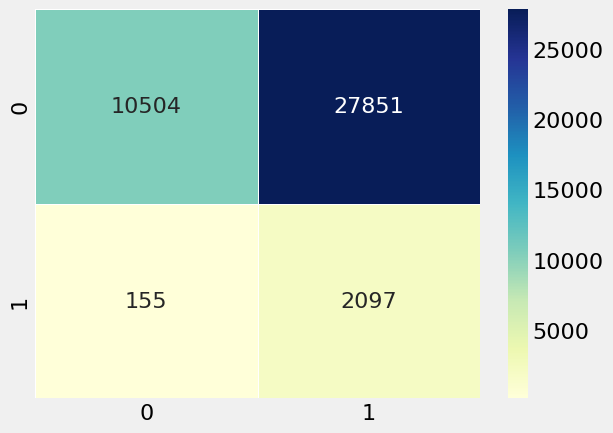

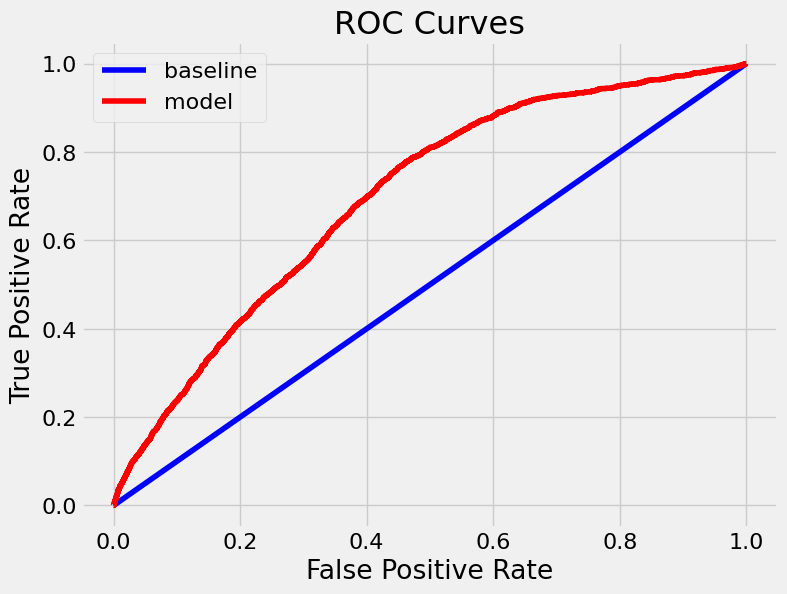

In [190]:
# logistic regression RSCV
from sklearn.model_selection import RandomizedSearchCV

'''
param_grid_dtc = {
    'criterion': ['gini', 'entropy'],  # Split criterion (default: 'gini')
    'splitter': ['best', 'random'],   # Strategy to choose the split at each node (default: 'best')
    'max_depth': list(range(1, 21)), # Maximum depth of the tree (default: None)
    'min_samples_split': list(range(2, 10, 2)),  # Minimum number of samples required to split an internal node (default: 2)
    'min_samples_leaf': [1, 2, 4],   # Minimum number of samples required to be at a leaf node (default: 1)
    'max_features': [None, 'auto', 'sqrt', 'log2'],  # Number of features to consider when looking for the best split (default: None)
    'random_state': [RSEED]  # Seed for random number generator (default: None)
}

# Hyperparameter grid for forest
param_grid_rfc = {
    'n_estimators': list(range(10, 100, 10)),
    'max_depth': list(range(1, 21)),
    'max_features': ['auto', 'sqrt', None],
    #'max_leaf_nodes': list(range(10, 51)),
    #'min_samples_split': list(range(2, 11, 2)),
    'bootstrap': [True, False]
}
'''

#Logistic Regression param grid
param_grid_lr = {
    'penalty': ['l1', 'l2'],  # Regularization penalty (L1 or L2)
    'C': [0.001, 0.01, 0.1, 1.0, 10.0],  # Inverse of regularization strength
    'solver': ['liblinear', 'lbfgs', 'saga'],  # Algorithm to use for optimization
    'max_iter': [100, 200, 300]  # Maximum number of iterations for optimization
}
'''
param_grid_lda = {
    'solver': ['svd', 'lsqr', 'eigen'],  # Solver to use (default: 'svd')
    'shrinkage': [None, 'auto', 0.1, 0.5, 1.0],  # Shrinkage parameter (default: None)
    'n_components': [None, 1, 2, 3],  # Number of components for dimensionality reduction (default: None)
    'store_covariance': [False, True]  # Whether to store covariance matrices (default: False)
}

param_grid_gbc = {
    'n_estimators': [100, 200, 300],          # Number of boosting stages to be used (default: 100)
    'learning_rate': [0.01, 0.1, 0.2],       # Step size shrinkage used in update to prevent overfitting (default: 0.1)
    'max_depth': [3, 4, 5],                 # Maximum depth of individual trees (default: 3)
    'min_samples_split': [2, 3, 4],         # Minimum number of samples required to split an internal node (default: 2)
    'min_samples_leaf': [1, 2, 3],          # Minimum number of samples required to be at a leaf node (default: 1)
    'subsample': [0.8, 0.9, 1.0],           # Fraction of samples used for fitting the trees (default: 1.0)
    'random_state': [RSEED]                 # Random seed for reproducibility
}

'''

# Estimator for use in random search
#clasifier_dtc =  DecisionTreeClassifier(random_state = RSEED)
#clasifier_rfc = RandomForestClassifier(random_state = RSEED)
clasifier_lr = LogisticRegression(random_state = RSEED)
#clasifier_lda = LinearDiscriminantAnalysis()
#clasifier_gbc = GradientBoostingClassifier(random_state = RSEED)


# Create the random search model
#for estimator in clasifier_set:
rs = RandomizedSearchCV(clasifier_lr, param_grid_lr, n_jobs = -1, 
                        scoring = 'roc_auc', cv = 8,
                        n_iter = 10, verbose = 5, random_state=RSEED)

rs.fit(X_train, y_train)

# classsifier
print("~" * 21)
print('for classifier: LogisticRegression()')
# Best score
print('Best score:', round(rs.best_score_, 3))
# Best parameters
print('Best parameters:', rs.best_params_)
print("~" * 21)
print()

best_model = rs.best_estimator_

y_pred_rs = best_model.predict(X_test)


# statistics output
cm_rs = confusion_matrix(y_test, y_pred_rs)
cm = cm_rs
model = best_model
y_pred = y_pred_rs

# Make probability predictions
X_train_probs = model.predict_proba(X_train)[:, 1]
X_test_probs = model.predict_proba(X_test)[:, 1]

X_train_predictions = model.predict(X_train)

from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

print(f'Train ROC AUC Score: {roc_auc_score(y_train, X_train_probs)}')
print(f'Test ROC AUC  Score: {roc_auc_score(y_test, X_test_probs)}')
print("--------"*10)
print(f'Baseline ROC AUC: {roc_auc_score(y_test, [1 for _ in range(len(y_test))])}')
print("--------"*10)
# Print classification report of our model
print(classification_report(y_test, y_pred))
print("--------"*10)

# Evaluate the model with a confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5);


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

print("--------"*10)
# Plot formatting
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18

# Calculate false positive rates and true positive rates
base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
model_fpr, model_tpr, _ = roc_curve(y_test, X_test_probs)

plt.figure(figsize = (8, 6))
plt.rcParams['font.size'] = 16
    
# Plot both curves
plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
plt.plot(model_fpr, model_tpr, 'r', label = 'model')
plt.legend()
plt.xlabel('False Positive Rate'); 
plt.ylabel('True Positive Rate'); plt.title('ROC Curves')
plt.show()

In [ ]:
# linear discrimination analysis RSCV
from sklearn.model_selection import RandomizedSearchCV

'''
param_grid_dtc = {
    'criterion': ['gini', 'entropy'],  # Split criterion (default: 'gini')
    'splitter': ['best', 'random'],   # Strategy to choose the split at each node (default: 'best')
    'max_depth': list(range(1, 21)), # Maximum depth of the tree (default: None)
    'min_samples_split': list(range(2, 10, 2)),  # Minimum number of samples required to split an internal node (default: 2)
    'min_samples_leaf': [1, 2, 4],   # Minimum number of samples required to be at a leaf node (default: 1)
    'max_features': [None, 'auto', 'sqrt', 'log2'],  # Number of features to consider when looking for the best split (default: None)
    'random_state': [RSEED]  # Seed for random number generator (default: None)
}

# Hyperparameter grid for forest
param_grid_rfc = {
    'n_estimators': list(range(10, 100, 10)),
    'max_depth': list(range(1, 21)),
    'max_features': ['auto', 'sqrt', None],
    #'max_leaf_nodes': list(range(10, 51)),
    #'min_samples_split': list(range(2, 11, 2)),
    'bootstrap': [True, False]
}

#Logistic Regression param grid
param_grid_lr = {
    'penalty': ['l1', 'l2'],  # Regularization penalty (L1 or L2)
    'C': [0.001, 0.01, 0.1, 1.0, 10.0],  # Inverse of regularization strength
    'solver': ['liblinear', 'lbfgs', 'saga'],  # Algorithm to use for optimization
    'max_iter': [100, 200, 300]  # Maximum number of iterations for optimization
}
'''
# Linear Disc Analysis
param_grid_lda = {
    'solver': ['svd', 'lsqr', 'eigen'],  # Solver to use (default: 'svd')
    'shrinkage': [None, 'auto', 0.1, 0.5, 1.0],  # Shrinkage parameter (default: None)
    'n_components': [None, 1, 2, 3],  # Number of components for dimensionality reduction (default: None)
    'store_covariance': [False, True]  # Whether to store covariance matrices (default: False)
}
'''
param_grid_gbc = {
    'n_estimators': [100, 200, 300],          # Number of boosting stages to be used (default: 100)
    'learning_rate': [0.01, 0.1, 0.2],       # Step size shrinkage used in update to prevent overfitting (default: 0.1)
    'max_depth': [3, 4, 5],                 # Maximum depth of individual trees (default: 3)
    'min_samples_split': [2, 3, 4],         # Minimum number of samples required to split an internal node (default: 2)
    'min_samples_leaf': [1, 2, 3],          # Minimum number of samples required to be at a leaf node (default: 1)
    'subsample': [0.8, 0.9, 1.0],           # Fraction of samples used for fitting the trees (default: 1.0)
    'random_state': [RSEED]                 # Random seed for reproducibility
}
'''

# Estimator for use in random search
#clasifier_dtc =  DecisionTreeClassifier(random_state = RSEED)
#clasifier_rfc = RandomForestClassifier(random_state = RSEED)
#estimator =  KNeighborsClassifier()
#clasifier_lr = LogisticRegression(random_state = RSEED)
clasifier_lda = LinearDiscriminantAnalysis()
#clasifier_gbc = GradientBoostingClassifier(random_state = RSEED)

#clasifier_set = [clasifier_dtc, clasifier_rfc, clasifier_lr, clasifier_lda, clasifier_gbc]
#param_grid_set = []

# Create the random search model
#for estimator in clasifier_set:
rs = RandomizedSearchCV(clasifier_lda, param_grid_lda, n_jobs = -1, 
                        scoring = 'roc_auc', cv = 8,
                        n_iter = 10, verbose = 5, random_state=RSEED)

rs.fit(X_train, y_train)

# classsifier
print("~" * 21)
print('for classifier: LinearDiscriminationAnalysis()')
# Best score
print('Best score:', round(rs.best_score_, 3))
# Best parameters
print('Best parameters:', rs.best_params_)
print("~" * 21)
print()

best_model = rs.best_estimator_

y_pred_rs = best_model.predict(X_test)


# statistics output
cm_rs = confusion_matrix(y_test, y_pred_rs)
cm = cm_rs
model = best_model
y_pred = y_pred_rs

# Make probability predictions
X_train_probs = model.predict_proba(X_train)[:, 1]
X_test_probs = model.predict_proba(X_test)[:, 1]

X_train_predictions = model.predict(X_train)

from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

print(f'Train ROC AUC Score: {roc_auc_score(y_train, X_train_probs)}')
print(f'Test ROC AUC  Score: {roc_auc_score(y_test, X_test_probs)}')
print("--------"*10)
print(f'Baseline ROC AUC: {roc_auc_score(y_test, [1 for _ in range(len(y_test))])}')
print("--------"*10)
# Print classification report of our model
print(classification_report(y_test, y_pred))
print("--------"*10)

# Evaluate the model with a confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5);


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

print("--------"*10)
# Plot formatting
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18

# Calculate false positive rates and true positive rates
base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
model_fpr, model_tpr, _ = roc_curve(y_test, X_test_probs)

plt.figure(figsize = (8, 6))
plt.rcParams['font.size'] = 16
    
# Plot both curves
plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
plt.plot(model_fpr, model_tpr, 'r', label = 'model')
plt.legend()
plt.xlabel('False Positive Rate'); 
plt.ylabel('True Positive Rate'); plt.title('ROC Curves')
plt.show()

In [ ]:
# gradient boosting RSCV
from sklearn.model_selection import RandomizedSearchCV

'''
param_grid_dtc = {
    'criterion': ['gini', 'entropy'],  # Split criterion (default: 'gini')
    'splitter': ['best', 'random'],   # Strategy to choose the split at each node (default: 'best')
    'max_depth': list(range(1, 21)), # Maximum depth of the tree (default: None)
    'min_samples_split': list(range(2, 10, 2)),  # Minimum number of samples required to split an internal node (default: 2)
    'min_samples_leaf': [1, 2, 4],   # Minimum number of samples required to be at a leaf node (default: 1)
    'max_features': [None, 'auto', 'sqrt', 'log2'],  # Number of features to consider when looking for the best split (default: None)
    'random_state': [RSEED]  # Seed for random number generator (default: None)
}

# Hyperparameter grid for forest
param_grid_rfc = {
    'n_estimators': list(range(10, 100, 10)),
    'max_depth': list(range(1, 21)),
    'max_features': ['auto', 'sqrt', None],
    #'max_leaf_nodes': list(range(10, 51)),
    #'min_samples_split': list(range(2, 11, 2)),
    'bootstrap': [True, False]
}



#Logistic Regression param grid
param_grid_lr = {
    'penalty': ['l1', 'l2'],  # Regularization penalty (L1 or L2)
    'C': [0.001, 0.01, 0.1, 1.0, 10.0],  # Inverse of regularization strength
    'solver': ['liblinear', 'lbfgs', 'saga'],  # Algorithm to use for optimization
    'max_iter': [100, 200, 300]  # Maximum number of iterations for optimization
}

param_grid_lda = {
    'solver': ['svd', 'lsqr', 'eigen'],  # Solver to use (default: 'svd')
    'shrinkage': [None, 'auto', 0.1, 0.5, 1.0],  # Shrinkage parameter (default: None)
    'n_components': [None, 1, 2, 3],  # Number of components for dimensionality reduction (default: None)
    'store_covariance': [False, True]  # Whether to store covariance matrices (default: False)
}
'''
param_grid_gbc = {
    'n_estimators': [100, 200, 300],          # Number of boosting stages to be used (default: 100)
    'learning_rate': [0.01, 0.1, 0.2],       # Step size shrinkage used in update to prevent overfitting (default: 0.1)
    'max_depth': [3, 4, 5],                 # Maximum depth of individual trees (default: 3)
    'min_samples_split': [2, 3, 4],         # Minimum number of samples required to split an internal node (default: 2)
    'min_samples_leaf': [1, 2, 3],          # Minimum number of samples required to be at a leaf node (default: 1)
    'subsample': [0.8, 0.9, 1.0],           # Fraction of samples used for fitting the trees (default: 1.0)
    'random_state': [RSEED]                 # Random seed for reproducibility
}


# Estimator for use in random search
#clasifier_dtc =  DecisionTreeClassifier(random_state = RSEED)
#clasifier_rfc = RandomForestClassifier(random_state = RSEED)
#estimator =  KNeighborsClassifier()
#clasifier_lr = LogisticRegression(random_state = RSEED)
#clasifier_lda = LinearDiscriminantAnalysis()
clasifier_gbc = GradientBoostingClassifier(random_state = RSEED)


# Create the random search model
#for estimator in clasifier_set:
rs = RandomizedSearchCV(clasifier_gbc, param_grid_gbc, n_jobs = -1, 
                        scoring = 'roc_auc', cv = 8,
                        n_iter = 10, verbose = 5, random_state=RSEED)

rs.fit(X_train, y_train)

# classsifier
print("~" * 21)
print('for classifier: GradientBoostingClassifier()')
# Best score
print('Best score:', round(rs.best_score_, 3))
# Best parameters
print('Best parameters:', rs.best_params_)
print("~" * 21)
print()

best_model = rs.best_estimator_

y_pred_rs = best_model.predict(X_test)


# statistics output
cm_rs = confusion_matrix(y_test, y_pred_rs)
cm = cm_rs
model = best_model
y_pred = y_pred_rs

# Make probability predictions
X_train_probs = model.predict_proba(X_train)[:, 1]
X_test_probs = model.predict_proba(X_test)[:, 1]

X_train_predictions = model.predict(X_train)

from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

print(f'Train ROC AUC Score: {roc_auc_score(y_train, X_train_probs)}')
print(f'Test ROC AUC  Score: {roc_auc_score(y_test, X_test_probs)}')
print("--------"*10)
print(f'Baseline ROC AUC: {roc_auc_score(y_test, [1 for _ in range(len(y_test))])}')
print("--------"*10)
# Print classification report of our model
print(classification_report(y_test, y_pred))
print("--------"*10)

# Evaluate the model with a confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5);


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

print("--------"*10)
# Plot formatting
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18

# Calculate false positive rates and true positive rates
base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
model_fpr, model_tpr, _ = roc_curve(y_test, X_test_probs)

plt.figure(figsize = (8, 6))
plt.rcParams['font.size'] = 16
    
# Plot both curves
plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
plt.plot(model_fpr, model_tpr, 'r', label = 'model')
plt.legend()
plt.xlabel('False Positive Rate'); 
plt.ylabel('True Positive Rate'); plt.title('ROC Curves')
plt.show()


*asses*

Train ROC AUC Score: 0.9963621399531182
Test ROC AUC  Score: 0.740178559788619
--------------------------------------------------------------------------------
Baseline ROC AUC: 0.5
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.96      0.90      0.93     38271
         1.0       0.17      0.32      0.22      2335

    accuracy                           0.87     40606
   macro avg       0.56      0.61      0.57     40606
weighted avg       0.91      0.87      0.89     40606

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


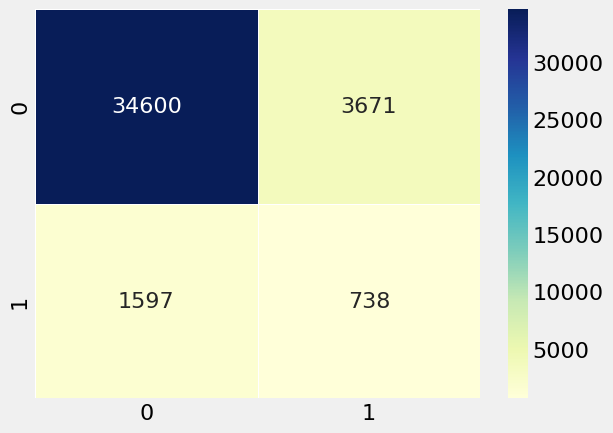

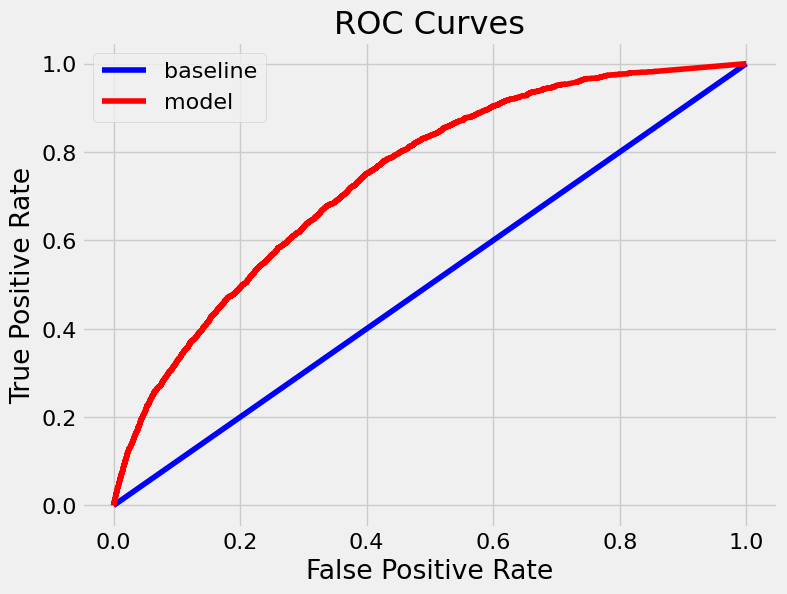

In [28]:
# adjust variables
cm_rs = confusion_matrix(y_test, y_pred_rs)
cm = cm_rs
model = best_model
y_pred = y_pred_rs

# Make probability predictions
X_train_probs = model.predict_proba(X_train)[:, 1]
X_test_probs = model.predict_proba(X_test)[:, 1]

X_train_predictions = model.predict(X_train)

from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

print(f'Train ROC AUC Score: {roc_auc_score(y_train, X_train_probs)}')
print(f'Test ROC AUC  Score: {roc_auc_score(y_test, X_test_probs)}')
print("--------"*10)
print(f'Baseline ROC AUC: {roc_auc_score(y_test, [1 for _ in range(len(y_test))])}')
print("--------"*10)
# Print classification report of our model
print(classification_report(y_test, y_pred))
print("--------"*10)

# Evaluate the model with a confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5);


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

print("--------"*10)
# Plot formatting
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18

# Calculate false positive rates and true positive rates
base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
model_fpr, model_tpr, _ = roc_curve(y_test, X_test_probs)

plt.figure(figsize = (8, 6))
plt.rcParams['font.size'] = 16
    
# Plot both curves
plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
plt.plot(model_fpr, model_tpr, 'r', label = 'model')
plt.legend()
plt.xlabel('False Positive Rate'); 
plt.ylabel('True Positive Rate'); plt.title('ROC Curves')
plt.show()



## linear regression

In [ ]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()

lin_reg.fit(X_train, y_train)
y_pred_lr = lin_reg.predict(X_test)

cm_lr = confusion_matrix(y_test, y_pred_rs)
sns.heatmap(cm_lr, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5);

## logistic regression

Train ROC AUC Score: 0.6755576464337245
Test ROC AUC  Score: 0.680308536713577
--------------------------------------------------------------------------------
Baseline ROC AUC: 0.5
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.97      0.56      0.71     38271
         1.0       0.09      0.70      0.16      2335

    accuracy                           0.57     40606
   macro avg       0.53      0.63      0.44     40606
weighted avg       0.92      0.57      0.68     40606

--------------------------------------------------------------------------------


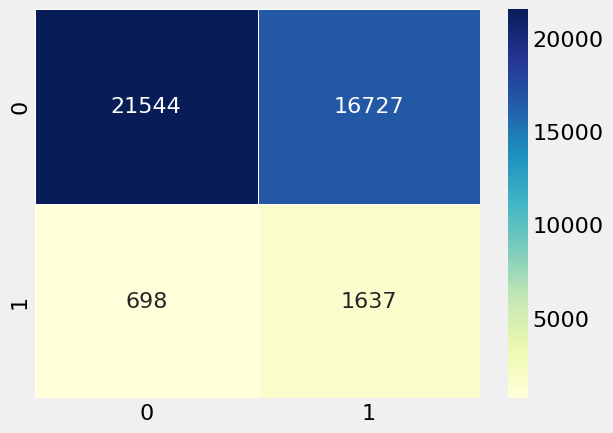

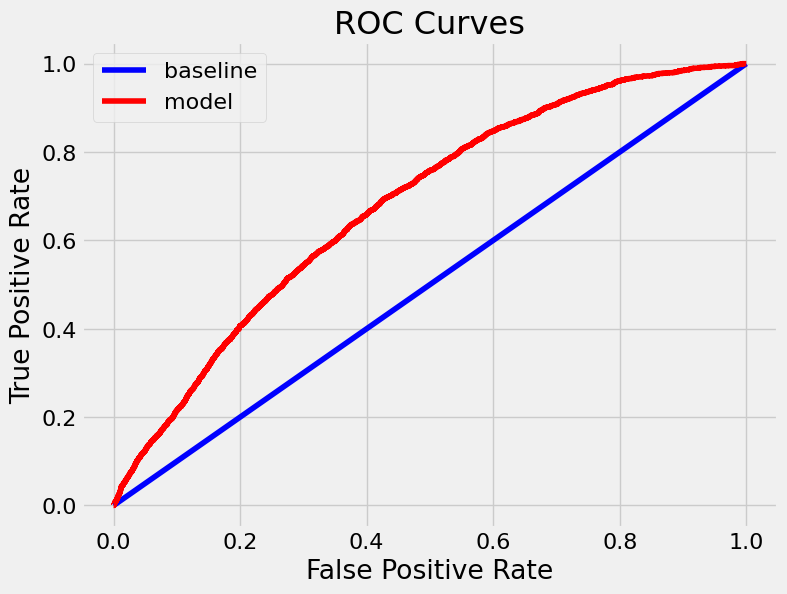

In [24]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)


#sns.heatmap(cm_logr, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5);

# adjust variables
cm_logr = confusion_matrix(y_test, y_pred)
cm = cm_logr
model = lr
y_pred = y_pred_lr

# Make probability predictions
X_train_probs = model.predict_proba(X_train)[:, 1]
X_test_probs = model.predict_proba(X_test)[:, 1]

X_train_predictions = model.predict(X_train)

from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

print(f'Train ROC AUC Score: {roc_auc_score(y_train, X_train_probs)}')
print(f'Test ROC AUC  Score: {roc_auc_score(y_test, X_test_probs)}')
print("--------"*10)
print(f'Baseline ROC AUC: {roc_auc_score(y_test, [1 for _ in range(len(y_test))])}')
print("--------"*10)
# Print classification report of our model
print(classification_report(y_test, y_pred))
print("--------"*10)

# Evaluate the model with a confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5);



from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve


# Plot formatting
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18

# Calculate false positive rates and true positive rates
base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
model_fpr, model_tpr, _ = roc_curve(y_test, X_test_probs)

plt.figure(figsize = (8, 6))
plt.rcParams['font.size'] = 16
    
# Plot both curves
plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
plt.plot(model_fpr, model_tpr, 'r', label = 'model')
plt.legend()
plt.xlabel('False Positive Rate'); 
plt.ylabel('True Positive Rate'); plt.title('ROC Curves')
plt.show()

# Create Ouput file

In [ ]:
submission = pd.DataFrame(
    {
        'client_id': sub_client_id,
        'target': preds['target']
    }
)

submission.head()

In [132]:
OUTPUT_DIR = "data/output/"
submission.to_csv(f'{OUTPUT_DIR}/submission.csv', index=False)

# Modules required

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## Tips 
- Thorough EDA and incorporating domain knowledge
- Re-grouping categorical features
- More feature engineering(try utilizing some date-time features)
- Target balancing - oversampling, undersampling, SMOTE, scale_pos_weight
- Model ensembling
- Train-test split or cross-validation


# ******************* GOOD LUCK!!! ***************************